In [5]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np


import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.8.2')
pyro.set_rng_seed(0)

In [6]:
# note that this helper function does three different things:
# (i) plots the observed data;
# (ii) plots the predictions from the learned GP after conditioning on data;
# (iii) plots samples from the GP prior (with no conditioning on observed data)


def plot(
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        ax.plot(X.numpy(), y.numpy(), "kx")
    if plot_predictions:
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    ax.set_xlim(-0.5, 5.5)

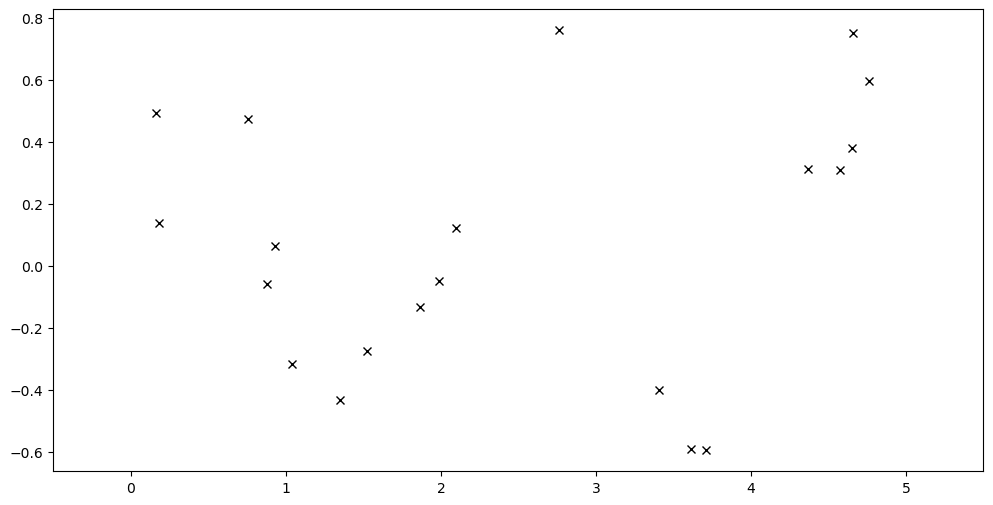

In [8]:
N = 20
X = dist.Uniform(0.0, 5.0).sample(sample_shape=(N,))
noise = dist.Normal(loc=0, scale=0.2)
y = 0.5 * torch.sin(3*X) +  noise.sample(sample_shape=(N,))
plot(plot_observed_data=True)

In [33]:
kernel = gp.kernels.RBF(input_dim=1, variance=torch.tensor(6.0), lengthscale=torch.tensor(0.05))
gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(0.1))

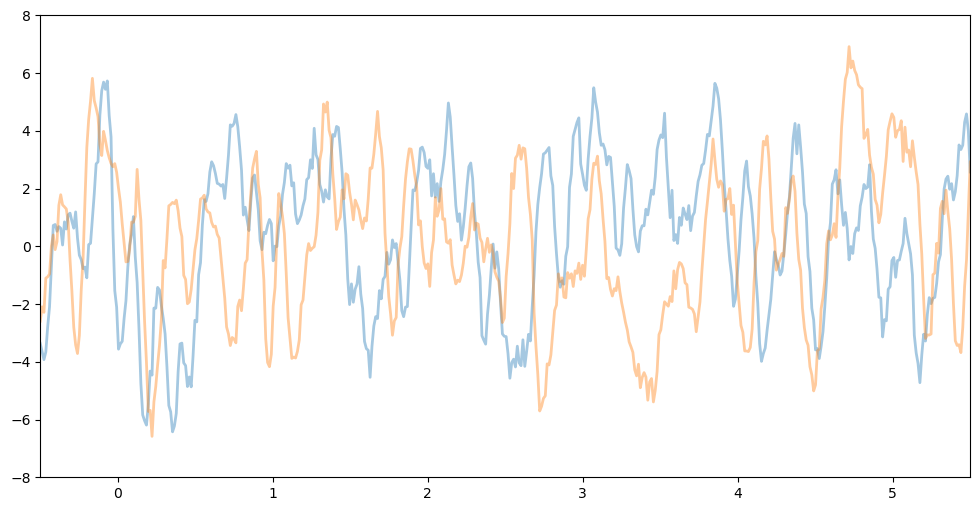

In [34]:
plot(model=gpr, kernel=kernel, n_prior_samples=2)
_ = plt.ylim((-8, 8))

In [35]:
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
variances = []
lengthscales = []
noises = []
num_steps = 2000 if not smoke_test else 2
for i in range(num_steps):
    variances.append(gpr.kernel.variance.item())
    noises.append(gpr.noise.item())
    lengthscales.append(gpr.kernel.lengthscale.item())
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

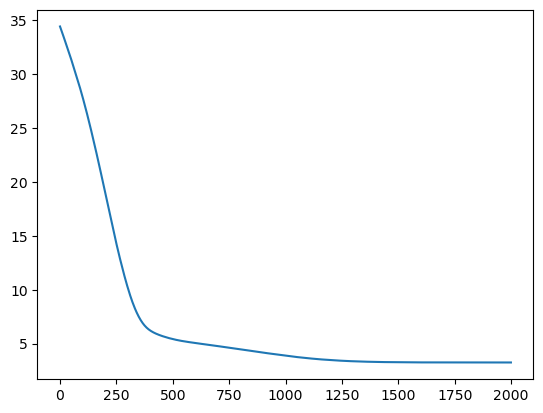

In [36]:
plt.plot(losses)

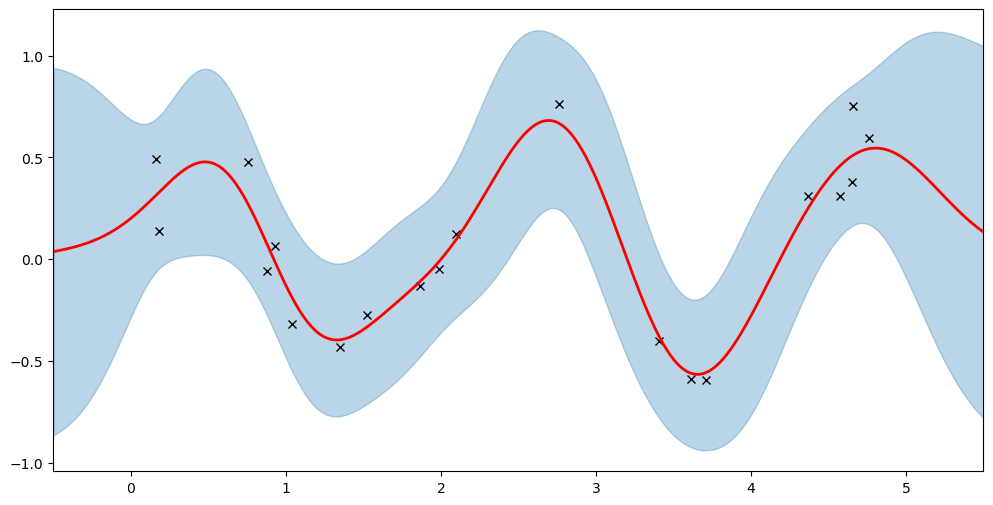

In [37]:
plot(model=gpr, plot_observed_data=True, plot_predictions=True)

In [38]:
gpr.kernel.variance.item()


0.19658678770065308

In [40]:
gpr.kernel.lengthscale.item()

0.42061784863471985

In [41]:
gpr.noise.item()


0.0239609032869339

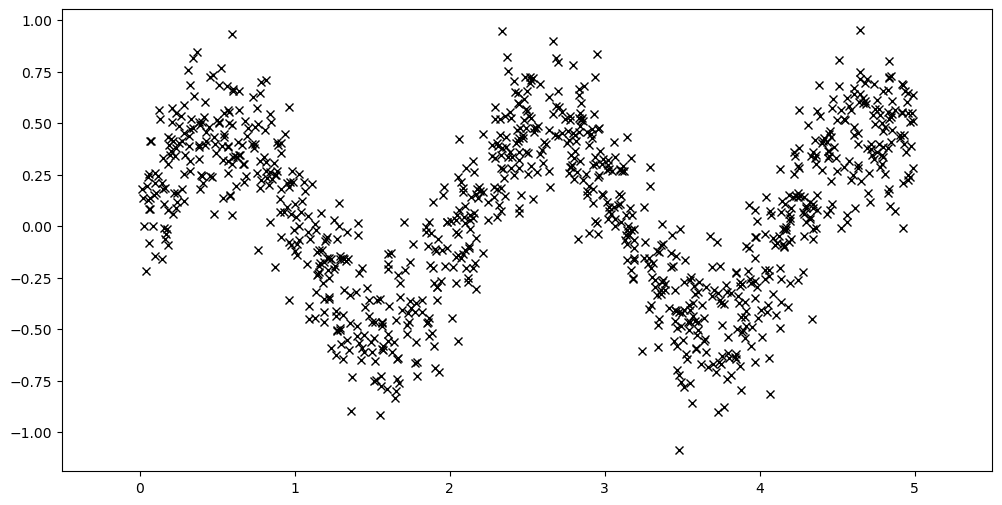

In [44]:
N = 1000
X = dist.Uniform(0.0, 5.0).sample(sample_shape=(N,))
y = 0.5 * torch.sin(3 * X) + dist.Normal(0.0, 0.2).sample(sample_shape=(N,))
plot(plot_observed_data=True)

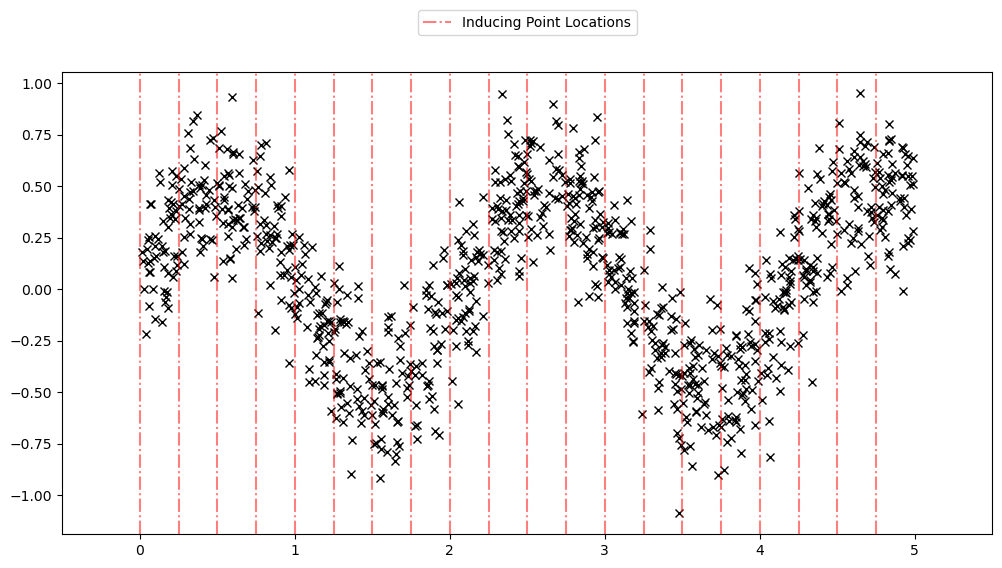

In [52]:
# initialize the inducing inputs
Xu = torch.arange(20.0) / 4.0

def plot_inducing_points(Xu, ax=None):
    for xu in Xu:
        g = ax.axvline(xu, color="red", linestyle="-.", alpha=0.5)
    ax.legend(
        handles=[g],
        labels=["Inducing Point Locations"],
        bbox_to_anchor=(0.5, 1.15),
        loc="upper center",
    )

plot(plot_observed_data=True)

plot_inducing_points(Xu, plt.gca())

In [53]:
# initialize the kernel and model
pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim=1)
# we increase the jitter for better numerical stability
sgpr = gp.models.SparseGPRegression(X, y, kernel, Xu=Xu, jitter=1.0e-5)

# the way we setup inference is similar to above
optimizer = torch.optim.Adam(sgpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
locations = []
variances = []
lengthscales = []
noises = []
num_steps = 2000 if not smoke_test else 2
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(sgpr.model, sgpr.guide)
    locations.append(sgpr.Xu.data.numpy().copy())
    variances.append(sgpr.kernel.variance.item())
    noises.append(sgpr.noise.item())
    lengthscales.append(sgpr.kernel.lengthscale.item())
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

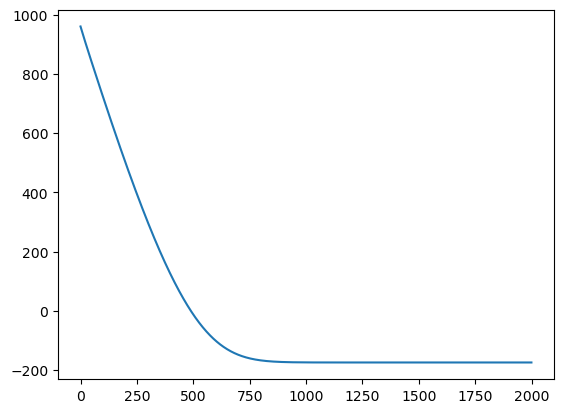

In [56]:
plt.plot(losses)


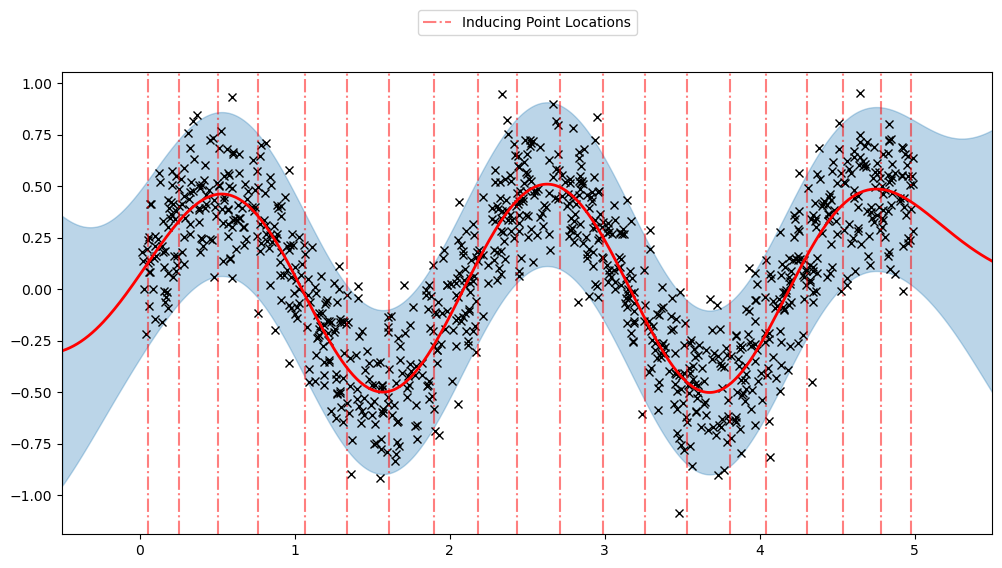

In [58]:
plot(model=sgpr, plot_observed_data=True, plot_predictions=True)
plot_inducing_points(sgpr.Xu.data.numpy(), plt.gca())

